# Pips Solver by Nicholas Hernandez and Kai Gowers

Below is a Pips Easy Example which we will use to demonstrate our solver. **This solver works for ALL configurations and difficulties.**

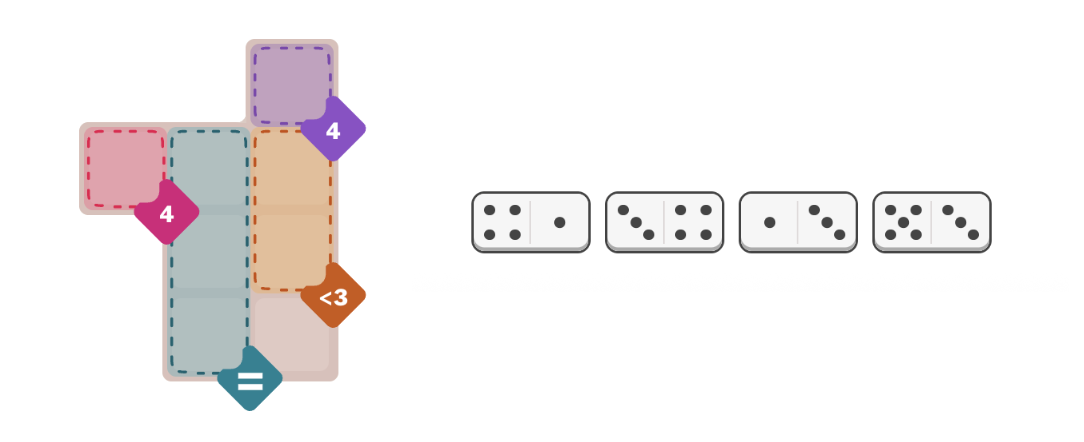

## Install Requirements

In [21]:
!pip install z3-solver

In [22]:
from z3 import *

## 1. Board Representation

### Board
The puzzle board is represented as a 2D array in which valid cells hold temporary placeholders
(e.g. numbers such as 0,1,2,...), while empty spaces contain the token "-1"

In [23]:
map = [
    [-1, -1, 0],
    [1, 2, 3],
    [-1, 4, 5],
    [-1, 6, 7],
]

### Edges

Two cells are adjacent if they are orthogonally next to each other (up, down, left, right).  From this, we construct the edge list:

In [24]:
def list_edges(board):

  edges = []
  for r in range(len(board)):
    for c in range(len(board[0])):
      if board[r][c] != -1:
        for dr, dc in [(0,1), (1,0), (0,-1), (-1,0)]:
          nr, nc = r + dr, c + dc
          if 0 <= nr < len(board) and 0 <= nc < len(board[0]) and board[nr][nc] != -1 and (board[nr][nc], board[r][c]) not in edges:
            edges.append((board[r][c], board[nr][nc]))

  return edges

num_cells = 8

cells = list(range(num_cells))

edges = list_edges(map)

edges

[(0, 3), (1, 2), (2, 3), (2, 4), (3, 5), (4, 5), (4, 6), (5, 7), (6, 7)]

### Domino Encoding

Each domino is a pair $(a,b)$ representing the pip values on its two halves.  
We index dominos as $d = 0,1,\dots,D-1$.  
Each domino may appear on any edge and in either orientation.

In [25]:
dominos = [(4,1), (3,4), (1,3), (5,3)]

### Region Constraints

Regions are represented as tuples:
$$
    (\text{cells},\; \text{op},\; \text{target}).
$$
The operator may be:
$$
    \text{sum\_eq}, \text{sum\_lt}, \text{sum\_gt}, \text{all\_eq}, \text{all\_diff}.
$$

In [26]:
# Regions: list of regions, each = (cells_in_region, op, target)
# op could be "sum_eq", "sum_lt", "sum_gt", "all_eq", "all_diff", etc.
regions = [
    ([1], "sum_eq", 4),
    ([2,4,6], "all_eq", 0),
    ([0], "sum_eq", 4),
    ([3,5], "sum_lt", 3)
]

## 2. Z3 Encoding

In [27]:
solver = Solver()
D = len(dominos)
E = len(edges)

### Placement variables

For each domino $d$, each edge $e$ of the cell-adjacency graph, and each
orientation $o \in \{0,1\}$ (normal or reversed), we create a Boolean variable
$$
    \text{place}_{d,e,o}.
$$
It is true exactly when domino $d$ is placed on edge $e$ with orientation $o$.

In [28]:
# Domino d is placed on edge e with orientation o (o = 0 means (a,b) and o = 1 means (b,a))
place = {}

for d in range(D):
  for e in range(E):
    for o in [0,1]:
      place[(d,e,o)] = Bool(f"place_{d}_{e}_{o}")

### Cell Value Variables

For each cell $c$ of the board we introduce an integer variable
$$
    v_c \in \{0,\dots,6\},
$$
representing the pip value ultimately assigned to that cell.

In [29]:
#Each cell value gets an int variable for its pip value, between 0 and 6 is the initial contraint

cell_val = [Int(f"v_{c}") for c in cells]
for c in cells:
    solver.add(And(cell_val[c] >= 0, cell_val[c] <= 6))

### Domino Placement Constraints

Each domino must be used exactly once.  
Since each possible placement corresponds to a Boolean variable, we enforce
$$
    \sum_{e,o} \text{place}_{d,e,o} = 1 \qquad\text{for every domino } d.
$$
This ensures that Z3 chooses one, and only one, placement-orientation pair for each domino.

In [30]:
for d in range(D):
    choices = [place[(d, e, o)] for e in range(E) for o in [0, 1]]
    solver.add(AtLeast(*choices, 1))  # at least one
    solver.add(AtMost(*choices, 1))   # at most one

### Cell Coverage Constraints

For each cell $c$, we precompute the set of all possible placements that could
cover it.  
Exactly one of these placements must be chosen:
$$
    \sum_{(d,e,o)\text{ covers }c} \text{place}_{d,e,o} = 1.
$$
This prevents overlap and guarantees that every cell is filled by exactly one domino-side.

In [31]:
touches = {c: [] for c in cells}  # list of (bool_var, value)

for d, (a, b) in enumerate(dominos):
    for e, (c1, c2) in enumerate(edges):
        for o in [0, 1]:
            p = place[(d, e, o)]
            if o == 0:
                v1, v2 = a, b
            else:
                v1, v2 = b, a
            # c1 gets v1, c2 gets v2
            touches[c1].append((p, v1))
            touches[c2].append((p, v2))

for c in cells:
    # exactly one of the placements that touch c is used
    bools = [p for (p, v) in touches[c]]
    solver.add(AtLeast(*bools, 1))
    solver.add(AtMost(*bools, 1))

### Cell Value Consistency

If a placement $(d,e,o)$ would assign pip value $x$ to a cell $c$, then whenever
that placement is selected, the value of the cell must match $x$.  
This is expressed with implications:
$$
    \text{place}_{d,e,o} \;\Rightarrow\; v_c = x.
$$
Because exactly one placement covering $c$ is true, this pins down $v_c$ to the
pip value contributed by the chosen domino.

In [32]:
for c in cells:
    # link cell_val[c] to those placements
    # If p is true, cell_val[c] == v
    # Because exactly one p is true, this pins down cell_val[c].
    constraints = []
    for (p, v) in touches[c]:
        constraints.append(Implies(p, cell_val[c] == v))

    solver.add(And(*constraints))

### Region Constraints

Each region $R$ on the board specifies a numerical rule on the cell values
within it.  
These rules translate naturally into arithmetic constraints over the $v_c$.
Examples include:
$$
    \sum_{c \in R} v_c = T, \qquad
    v_{c_1} = v_{c_2} \ \text{for all } c_1,c_2\in R,
$$
or other constraints. These formulas capture the semantics of the puzzle's region labels.

In [33]:
for cells_R, op, target in regions:
    vals = [cell_val[c] for c in cells_R]

    if op == "sum_eq":
        solver.add(Sum(vals) == target)

    elif op == "sum_lt":
        solver.add(Sum(vals) < target)

    elif op == "sum_gt":
        solver.add(Sum(vals) > target)

    elif op == "all_eq":   # all cells same value
        base = vals[0]
        solver.add(And([v == base for v in vals]))

    elif op == "all_diff": # all cells distinct
        solver.add(Distinct(vals))

## 3. Solving

We ask Z3 for a model:
$$
    \text{solver.check()} = \text{sat}
$$
and extract the orientation and position of each domino.

In [34]:
if solver.check() == sat:
    model = solver.model()
    # Read out cell values
    solved_vals = [model[cell_val[c]].as_long() for c in cells]

    # And also which domino went where
    placements = []
    for d in range(D):
        for e in range(E):
            for o in [0, 1]:
                if model.evaluate(place[(d, e, o)], model_completion=True):
                    placements.append((d, e, o))
    # Now you know exactly which domino is on which edge and orientation
else:
  placements = None
  print("No solution.")

placements

[(0, 0, 0), (1, 1, 1), (2, 5, 1), (3, 8, 1)]

## 4. Visualization

/tmp/ipython-input-4259849950.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


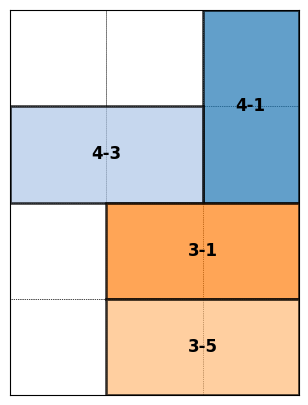

In [35]:
rows = len(map)
cols = len(map[0])

# node_id -> (row, col)
node_pos = {}
for r, row in enumerate(map):
    for c, val in enumerate(row):
        if val != -1:
            node_pos[val] = (r, c)

def placements_to_tiles(placements, dominos, edges, node_pos):
    tiles = []
    for dom_idx, edge_idx, flipped in placements:
        # Domino numbers
        a, b = dominos[dom_idx]
        if flipped == 1:
            a, b = b, a

        # Edge endpoints (node ids)
        n1, n2 = edges[edge_idx]

        # Convert node ids to (row, col)
        c1 = node_pos[n1]
        c2 = node_pos[n2]

        # Label shown on the tile - change to a+b if you want the sum
        label = f"{a}-{b}"   # or str(dom_idx), or a+b, etc.

        tiles.append({
            "cells": [c1, c2],
            "value": label,
        })

    return tiles

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_board(rows, cols, tiles, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect("equal")
    ax.invert_yaxis()

    # Draw grid
    for r in range(rows):
        for c in range(cols):
            rect = patches.Rectangle(
                (c, r), 1, 1,
                fill=False,
                linewidth=0.5,
                linestyle=":"
            )
            ax.add_patch(rect)

    cmap = plt.cm.get_cmap("tab20")
    for i, tile in enumerate(tiles):
        cells = tile["cells"]
        color = cmap(i % 20)

        rows_ = [r for (r, c) in cells]
        cols_ = [c for (r, c) in cells]
        min_r, max_r = min(rows_), max(rows_)
        min_c, max_c = min(cols_), max(cols_)
        x, y = min_c, min_r
        w = max_c - min_c + 1
        h = max_r - min_r + 1

        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor="black",
            facecolor=color,
            alpha=0.7,
        )
        ax.add_patch(rect)

        value = tile.get("value", "")
        cx = x + w / 2
        cy = y + h / 2
        ax.text(cx, cy, str(value), ha="center", va="center",
                fontsize=12, weight="bold")

    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
tiles = placements_to_tiles(placements, dominos, edges, node_pos)
plot_board(rows, cols, tiles)